In [751]:
from prophet import Prophet
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_absolute_error, r2_score
import itertools



## Data Preperation

In [752]:
# Load the data
data = pd.read_csv('MLTempDataset.csv')

# Preprocess the data
data['Datetime'] = pd.to_datetime(data['Datetime'])
data.set_index('Datetime', inplace=True)
data.drop(columns=['Datetime1'], inplace=True)

data

,Unnamed: 0,DAYTON_MW
Datetime,,
2022-01-04 00:00:00,0,20.867
2022-01-04 01:00:00,1,21.000
2022-01-04 02:00:00,2,20.867
2022-01-04 03:00:00,3,20.650
2022-01-04 04:00:00,4,20.400
...,...,...
2022-10-08 23:00:00,6671,27.350
2022-10-09 00:00:00,6672,26.800
2022-10-09 01:00:00,6673,26.450


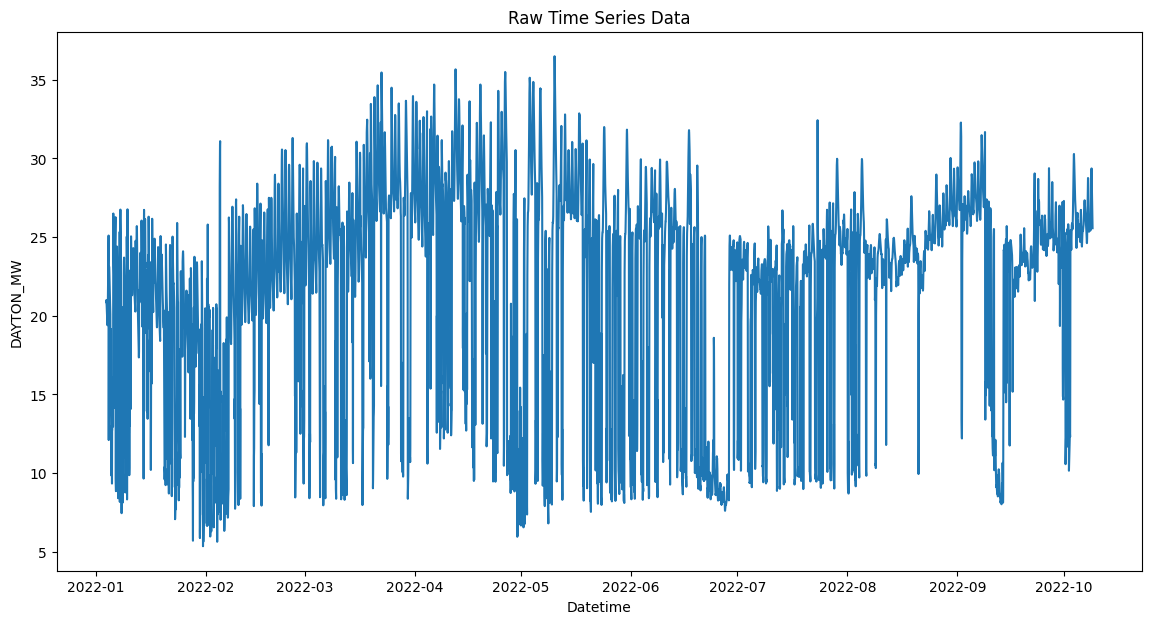

In [753]:
# Visualize the raw time series data
plt.figure(figsize=(14, 7))
plt.plot(data['DAYTON_MW'])
plt.title('Raw Time Series Data')
plt.xlabel('Datetime')
plt.ylabel('DAYTON_MW')
plt.show()

##  Exploratory Analysis

In [754]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6676 entries, 2022-01-04 00:00:00 to 2022-10-09 03:00:00
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  6676 non-null   int64  
 1   DAYTON_MW   6676 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 156.5 KB


In [755]:
data.isnull().sum()

Unnamed: 0    0
DAYTON_MW     0
dtype: int64

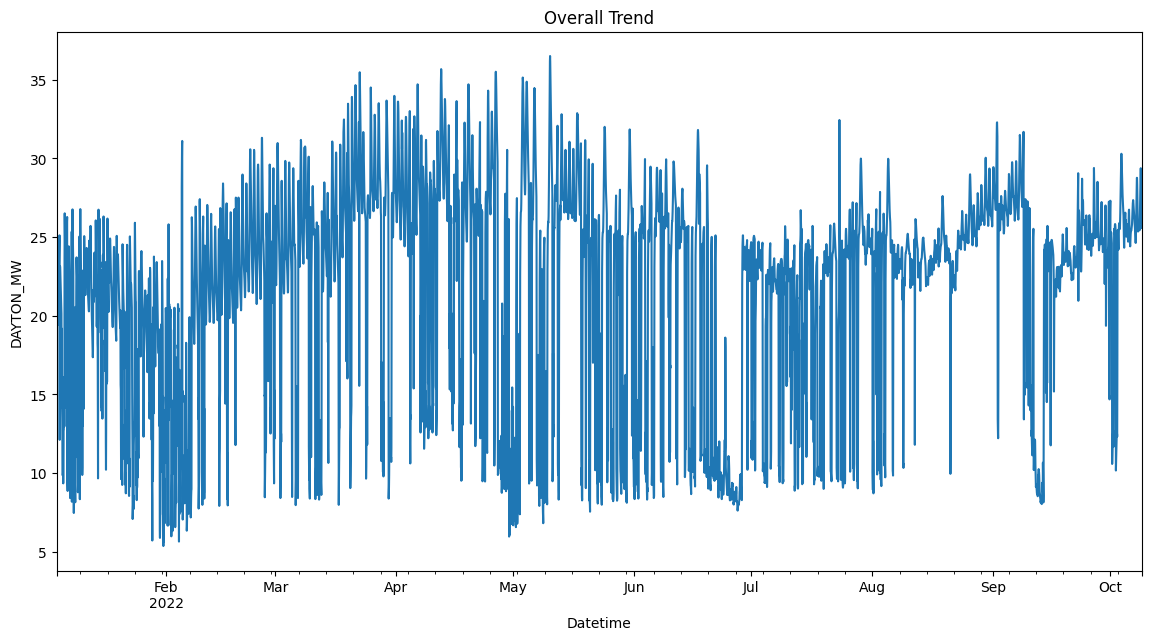

In [756]:
data['DAYTON_MW'].plot(figsize=(14, 7))
plt.title('Overall Trend')
plt.xlabel('Datetime')
plt.ylabel('DAYTON_MW')
plt.show()

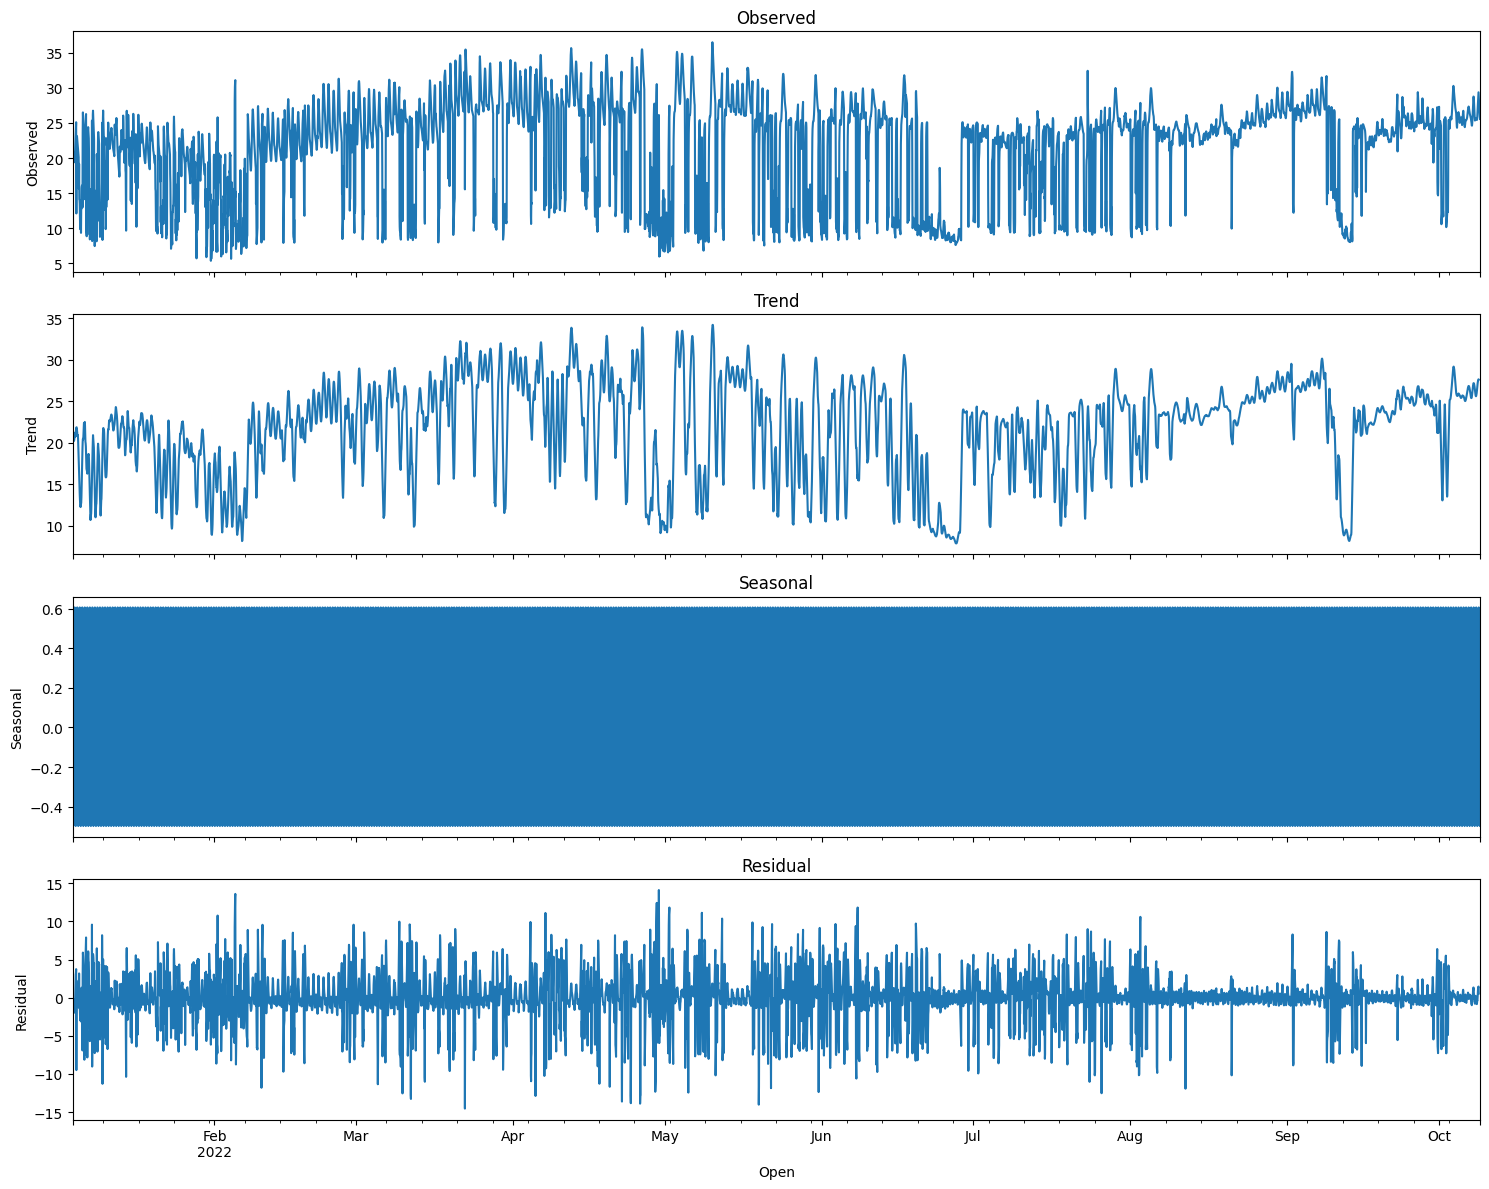

In [757]:
decomposition = seasonal_decompose(data['DAYTON_MW'], model='multiplicative', period=365)
result = seasonal_decompose(data['DAYTON_MW'], model='additive', period=12)
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15, 12), sharex=True)
result.observed.plot(ax=ax1, title='Observed')
ax1.set_ylabel('Observed')
result.trend.plot(ax=ax2, title='Trend')
ax2.set_ylabel('Trend')
result.seasonal.plot(ax=ax3, title='Seasonal')
ax3.set_ylabel('Seasonal')
result.resid.plot(ax=ax4, title='Residual')
ax4.set_ylabel('Residual')
ax4.set_xlabel('Open')
plt.tight_layout()
plt.show()

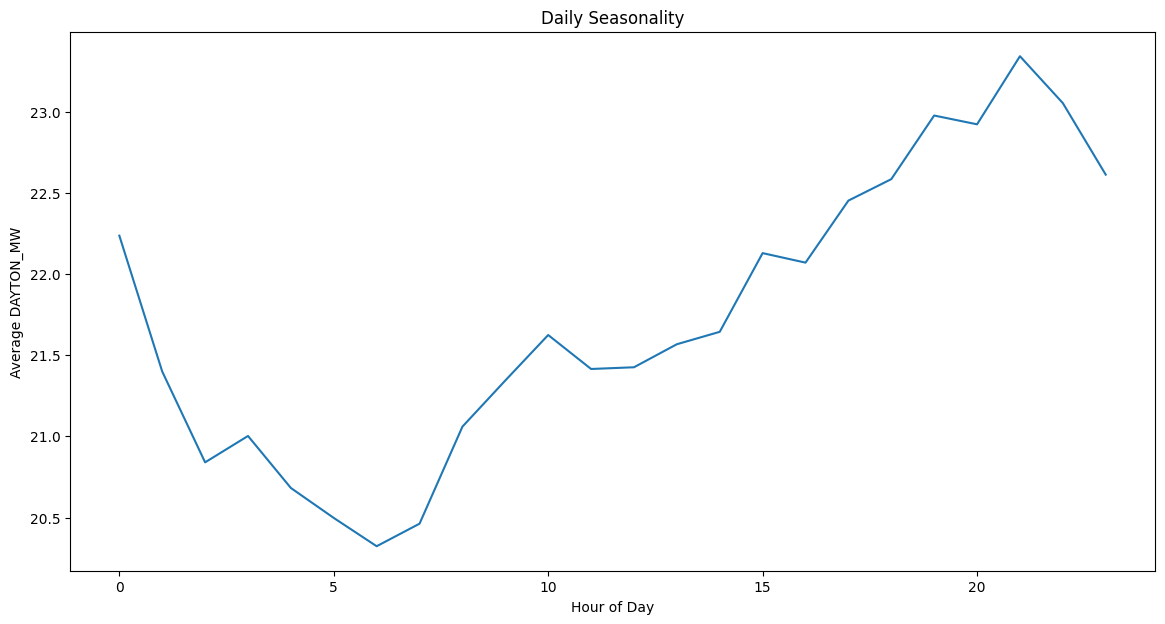

In [758]:
# Daily Seasonality 
data['hour'] = data.index.hour
daily_seasonality = data.groupby('hour')['DAYTON_MW'].mean()
daily_seasonality.plot(figsize=(14, 7))
plt.title('Daily Seasonality')
plt.xlabel('Hour of Day')
plt.ylabel('Average DAYTON_MW')
plt.show()

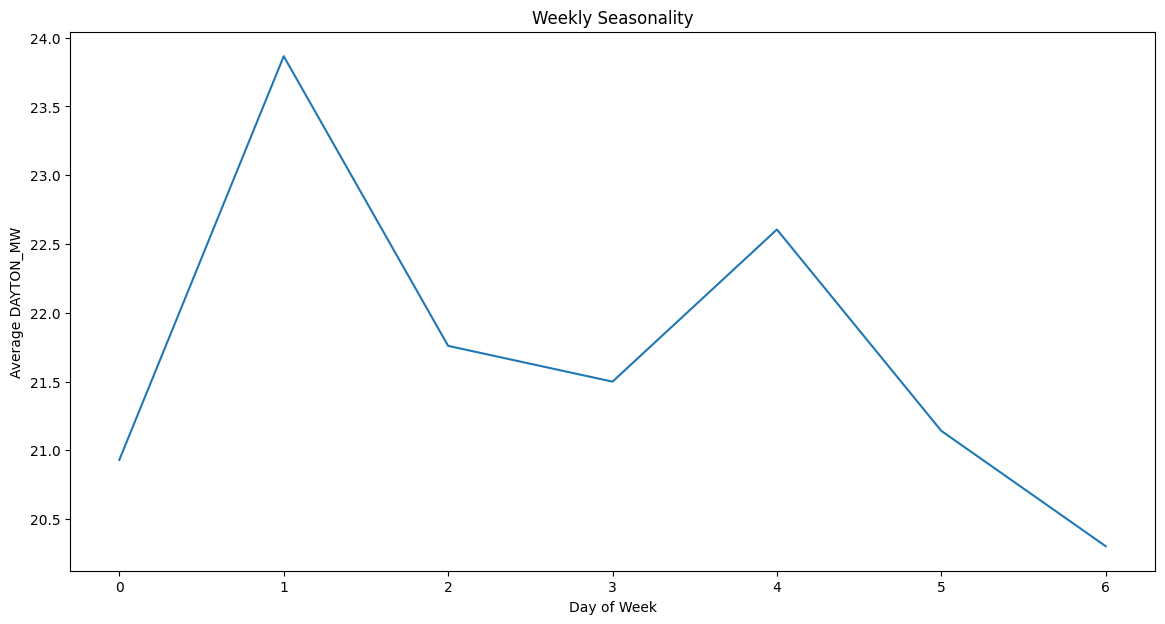

In [759]:
# Weekly Seasonality 
data['dayofweek'] = data.index.dayofweek
weekly_seasonality = data.groupby('dayofweek')['DAYTON_MW'].mean()
weekly_seasonality.plot(figsize=(14, 7))
plt.title('Weekly Seasonality')
plt.xlabel('Day of Week')
plt.ylabel('Average DAYTON_MW')
plt.show()

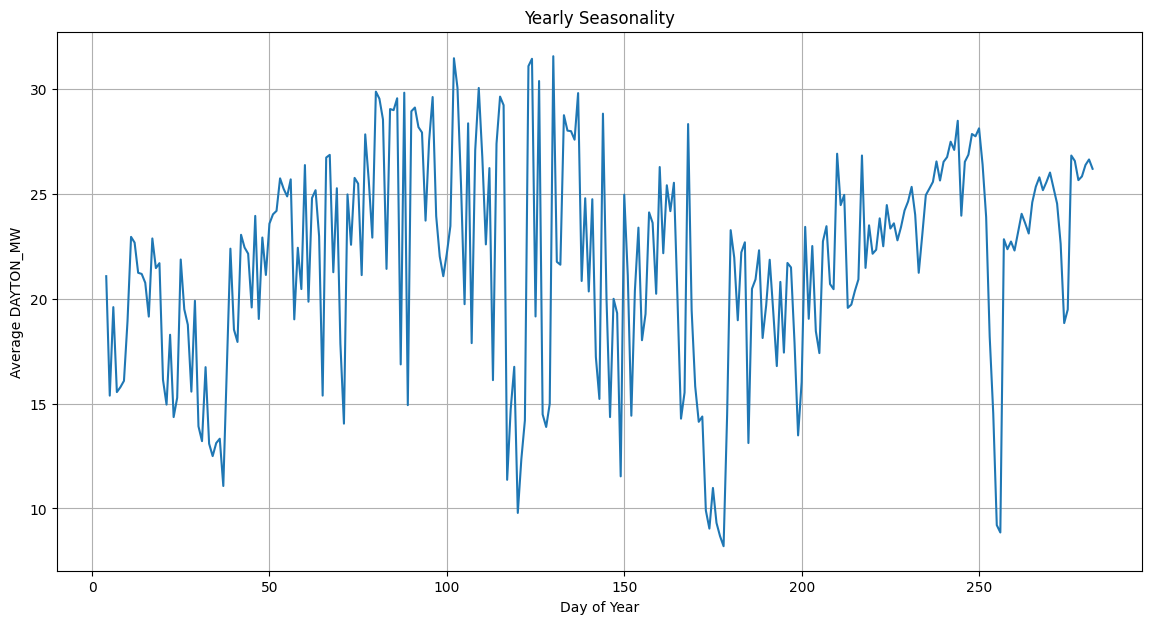

In [760]:
# Yearly Seasonality
data['day_of_year'] =  data.index.dayofyear
plt.figure(figsize=(14, 7))
data.groupby('day_of_year')['DAYTON_MW'].mean().plot()
plt.title('Yearly Seasonality')
plt.xlabel('Day of Year')
plt.ylabel('Average DAYTON_MW')
plt.grid(True)
plt.show()

## Prepare data for Prophet

In [761]:
# Split data into train and test sets
train_size = int(len(data) * 0.8)
train = data.iloc[:train_size]
test = data.iloc[train_size:]

In [762]:
train_df = train.reset_index()[['Datetime', 'DAYTON_MW']]
train_df.columns = ['ds', 'y']
test_df = test.reset_index()[['Datetime', 'DAYTON_MW']]
test_df.columns = ['ds', 'y']

In [763]:
# Initialize and fit the model with additional parameters
model = Prophet(
    daily_seasonality=True, 
    weekly_seasonality=True, 
    yearly_seasonality=True,  # Adjust as per data availability
    seasonality_mode= 'additive'
)

In [764]:
# Fit the model on the training data
model.fit(train_df)

12:07:22 - cmdstanpy - INFO - Chain [1] start processing
12:07:23 - cmdstanpy - INFO - Chain [1] done processing


In [765]:
len(test_df) 
# len(train)

1336

In [766]:
# Make future dataframe and predictions
future = model.make_future_dataframe(periods=len(test), freq='H')
forecast = model.predict(future)

C:\Users\71518\AppData\Roaming\Python\Python312\site-packages\prophet\forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(


In [767]:
print(forecast[['yhat', 'yhat_lower', 'yhat_upper']].tail())

           yhat  yhat_lower  yhat_upper
6671  25.436856   17.416588   33.645346
6672  24.636932   16.529165   32.760989
6673  23.955405   16.198747   32.251925
6674  23.506827   15.085933   31.435511
6675  23.205381   14.977088   31.989430


C:\Users\71518\AppData\Roaming\Python\Python312\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
C:\Users\71518\AppData\Roaming\Python\Python312\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


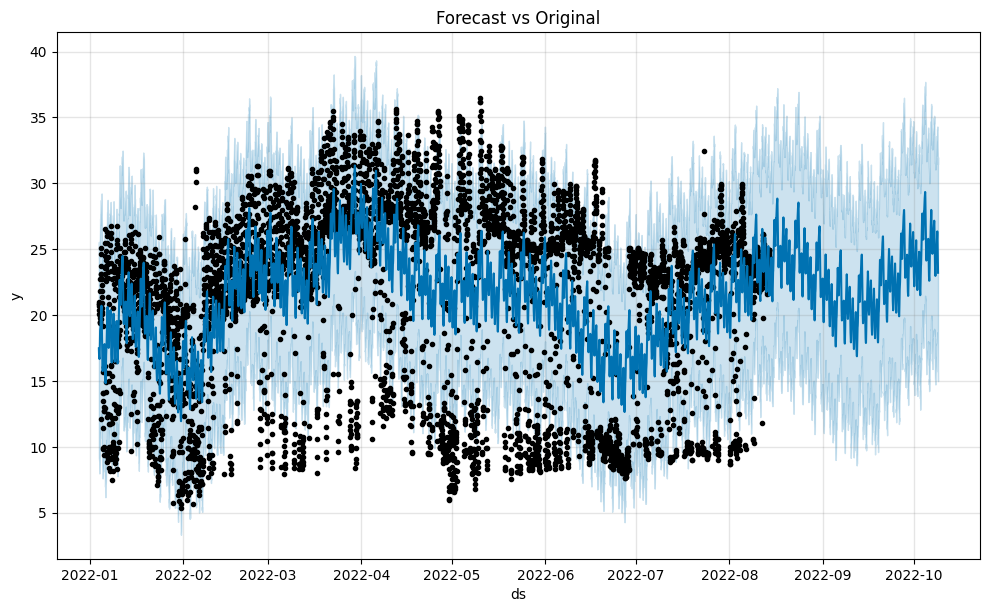

In [768]:
# Plot the forecast
fig = model.plot(forecast)
plt.title('Forecast vs Original')
plt.show()

C:\Users\71518\AppData\Roaming\Python\Python312\site-packages\prophet\plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
C:\Users\71518\AppData\Roaming\Python\Python312\site-packages\prophet\plot.py:397: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  artists += ax.plot(df_y['ds'].dt.to_pydatetime(), seas[name], ls='-',
C:\Users\71518\AppData\Roaming\Python\Python312\site-packages\prophet\plot.py:401: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime obje

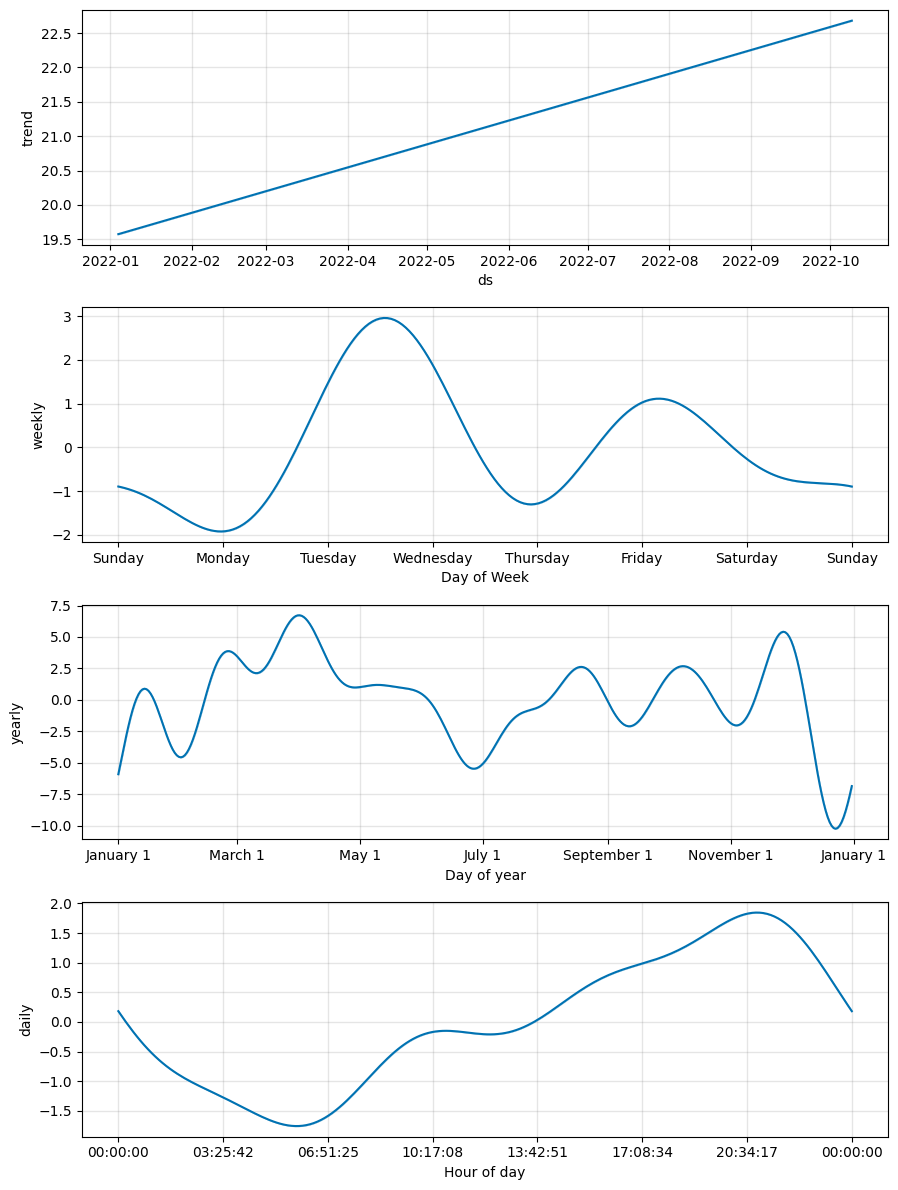

In [769]:
# Plot the components including yearly seasonality
fig2 = model.plot_components(forecast)
plt.show()

In [770]:
len(forecast), len(data)

(6676, 6676)

In [771]:
# Merge actual and forecasted data
forecast = forecast.set_index('ds')
results = data[['DAYTON_MW']].join(forecast[['yhat']], how='left')

In [772]:
test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1336 entries, 2022-08-14 12:00:00 to 2022-10-09 03:00:00
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   1336 non-null   int64  
 1   DAYTON_MW    1336 non-null   float64
 2   hour         1336 non-null   int32  
 3   dayofweek    1336 non-null   int32  
 4   day_of_year  1336 non-null   int32  
dtypes: float64(1), int32(3), int64(1)
memory usage: 47.0 KB


In [773]:
len(test), len(forecast[['yhat']])

(1336, 6676)

In [774]:
# Calculate metrics on test data
test_results = results.iloc[train_size:]
mae = mean_absolute_error(data['DAYTON_MW'], forecast['yhat'])
smae = mae / data['DAYTON_MW'].mean()
r2 = r2_score(data['DAYTON_MW'], forecast['yhat'])

print(f'MAE: {mae}, sMAE: {smae}, R2 Score: {r2}')


MAE: 4.871110590986029, sMAE: 0.2241032823946311, R2 Score: 0.21511483151792188


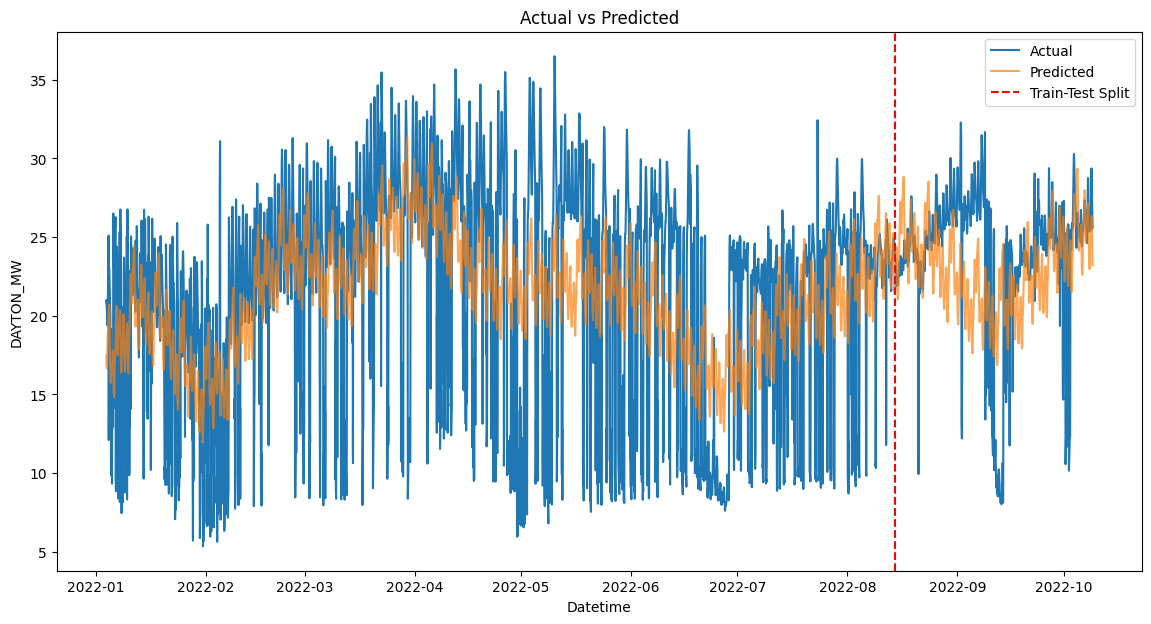

In [775]:
# Plot actual vs predicted with train and test data
plt.figure(figsize=(14, 7))
plt.plot(results.index, results['DAYTON_MW'], label='Actual')
plt.plot(results.index, results['yhat'], label='Predicted', alpha=0.7)
plt.axvline(x=train.index[-1], color='r', linestyle='--', label='Train-Test Split')
plt.title('Actual vs Predicted')
plt.xlabel('Datetime')
plt.ylabel('DAYTON_MW')
plt.legend()
plt.show()